In [44]:
import os

import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision import transforms

from miniai.imports import *
from miniai.datasets import *
from miniai.diffusion import *

### Get Tiny ImageNet

In [26]:
path_t = Path("tiny_imgnet/train")
path_v = Path("tiny_imgnet/valid")


In [29]:
class MemmapDataset(Dataset):
    def __init__(self, path, num_elems, emb_filename="tensor_embs.npmm", lat_filename="tensor_lats.npmm", emb_shape=(768), lat_shape=(4,8,8)):
        path_emb = path/emb_filename
        path_lat = path/lat_filename

        self.num_elems = num_elems
        self.emb_shape = (num_elems, emb_shape)
        self.lat_shape = (num_elems, *(lat_shape))
        
        self.embs = np.memmap(path_emb, dtype=np.float32, mode='r', shape=self.emb_shape)
        self.lats = np.memmap(path_lat, dtype=np.float32, mode='r', shape=self.lat_shape)

    def __len__(self):
        return self.num_elems

    def __getitem__(self, i):
        emb = torch.tensor(self.embs[i])
        lat = torch.tensor(self.lats[i])
        return emb, lat

In [48]:
def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0,0.999)
    eps = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*eps
    return (xt, t.to(device)), eps

In [63]:
def custom_collate(b):
    emb, lat = default_collate(b)
    (noised_lat, timestep), true_noise = noisify(lat)
    return (noised_lat, timestep, emb), true_noise

In [64]:
def custom_dl(ds):
    return DataLoader(ds, batch_size=32, collate_fn=custom_collate, num_workers=8)

In [65]:
tds = MemmapDataset(path_t, 100_000)
vds = MemmapDataset(path_v, 10_000)

In [66]:
dls = DataLoaders(custom_dl(tds), custom_dl(vds))

In [77]:
(noised_lat, timestep, emb), true_noise = next(iter(dls.train))
noised_lat.shape, timestep.shape, emb.shape, true_noise.shape

(torch.Size([32, 4, 8, 8]),
 torch.Size([32]),
 torch.Size([32, 768]),
 torch.Size([32, 4, 8, 8]))

In [78]:
class AttnCondUNet(nn.Module):
    def __init__(self, n_cemb, in_channels=4, out_channels=4, 
                 nfs=(224,448,672,896), num_layers=1, attn_chans=8, attn_start=1):
        super().__init__()
        self.n_temb = nf = nfs[0]
        n_emb = nf*4

        # TODO: Change 768 to not be hardcoded (n_cemb). We want this to be image_features.shape[1] 
        self.c_emb_mlp = nn.Sequential(lin(n_cemb, n_emb, norm=nn.BatchNorm1d), lin(n_emb, n_emb))
        self.t_emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d), lin(n_emb, n_emb))

        # In Conv
        self.conv_in = nn.Conv2d(in_channels, nf, kernel_size=3, padding=1)

        # Down Blocks
        self.downs = nn.ModuleList()
        n = len(nfs)

        for i in range(len(nfs)):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=len(nfs)-1, num_layers=num_layers,
                                        attn_chans=0 if i == n-attn_start else attn_chans))
        
        # Mid Blocks
        self.mid_block = EmbResBlock(n_emb, nfs[-1])

        # Up Blocks
        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(len(nfs)):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=len(nfs)-1, num_layers=num_layers+1,
                                    attn_chans=0 if i >= n-attn_start else attn_chans))

        # Out Conv
        self.conv_out = pre_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, inp):
        x,t,c = inp
        temb = timestep_embedding(t, self.n_temb)
        t_mlp = self.t_emb_mlp(temb)
        c_mlp = self.c_emb_mlp(c)
        emb = t_mlp + c_mlp
        x = self.conv_in(x)
        saved = [x]
        for block in self.downs: x = block(x, emb)
        saved += [p for o in self.downs for p in o.saved]
        x = self.mid_block(x, emb)
        for block in self.ups: x = block(x, emb, saved)
        x = self.conv_out(x)
        return x

In [81]:
lr = 1e-2
epochs = 1
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = AttnCondUNet(768, in_channels=4, out_channels=4, nfs=(32,64,128,256), num_layers=1)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.950,0,train
0.916,0,eval


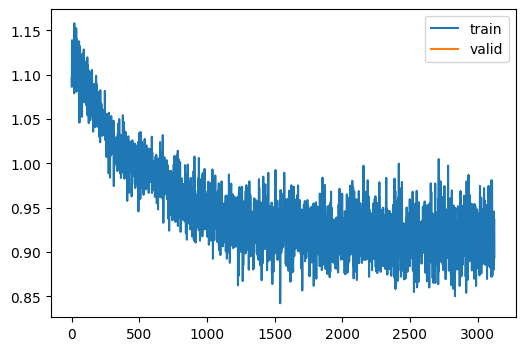

In [82]:
learn.fit(epochs)